In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install category_encoders
!pip install tune-sklearn
!pip install scikit-optimize
!pip install hyperopt
!pip install hpbandster

     |████████████████████████████████| 86 kB 2.6 MB/s 
     |████████████████████████████████| 40 kB 3.5 MB/s 
     |████████████████████████████████| 52.7 MB 138 kB/s 
     |████████████████████████████████| 226 kB 53.2 MB/s 
     |████████████████████████████████| 4.1 MB 31.5 MB/s 
     |████████████████████████████████| 125 kB 49.6 MB/s 
  Attempting uninstall: grpcio
    Found existing installation: grpcio 1.44.0
    Uninstalling grpcio-1.44.0:
      Successfully uninstalled grpcio-1.44.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow 2.8.0 requires tf-estimator-nightly==2.8.0.dev2021122109, which is not installed.
     |████████████████████████████████| 100 kB 3.5 MB/s 
     |████████████████████████████████| 51 kB 93 kB/s 
     |████████████████████████████████| 89 kB 4.8 MB/s 
     |████████████████████████████████| 4.7 MB 42.2 MB/s 
  Creat

In [ ]:
import pandas as pd
import numpy as np
import time 
import math
import multiprocessing


#for text pre-processing
import re, string
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import wordnet
from gensim.models.doc2vec import Doc2Vec, TaggedDocument
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
nltk.download('wordnet')


# sklearn
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.multioutput import MultiOutputRegressor
from sklearn.metrics import mean_squared_error, make_scorer
from sklearn.preprocessing import StandardScaler

# tune-sklearn
from tune_sklearn import TuneGridSearchCV, TuneSearchCV


# save model
from joblib import dump, load

# XGB 
from xgboost import XGBRegressor

#for word embedding
import gensim
from gensim.models import Word2Vec
from gensim.models.doc2vec import Doc2Vec
from gensim.corpora.wikicorpus import WikiCorpus
from gensim.test.utils import datapath

# for categorical encoding
import category_encoders as ce


import matplotlib.pyplot as plt
%matplotlib inline

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [ ]:
# Load Data
train_df = pd.read_csv('/content/drive/MyDrive/Project_ML/train.csv').dropna()
train_df.shape

(27480, 4)

In [ ]:
train_df.isna().sum()


textID           0
text             0
selected_text    0
sentiment        0
dtype: int64

In [ ]:
train_df['word_count'] = train_df['text'].apply(lambda x: len(str(x).split()))
print(train_df[train_df['sentiment']== 'positive']['word_count'].mean()) #Positive tweets
print(train_df[train_df['sentiment']== 'negative']['word_count'].mean()) #Negative tweets
print(train_df[train_df['sentiment']== 'neutral']['word_count'].mean()) #Neutral tweets
train_df

13.109881146585877
13.473203958360108
12.343887739498067


,textID,text,selected_text,sentiment,word_count
0,cb774db0d1,"I`d have responded, if I were going","I`d have responded, if I were going",neutral,7
1,549e992a42,Sooo SAD I will miss you here in San Diego!!!,Sooo SAD,negative,10
2,088c60f138,my boss is bullying me...,bullying me,negative,5
3,9642c003ef,what interview! leave me alone,leave me alone,negative,5
4,358bd9e861,"Sons of ****, why couldn`t they put them on t...","Sons of ****,",negative,14
...,...,...,...,...,...
27476,4eac33d1c0,wish we could come see u on Denver husband l...,d lost,negative,16
27477,4f4c4fc327,I`ve wondered about rake to. The client has ...,", don`t force",negative,23
27478,f67aae2310,Yay good for both of you. Enjoy the break - y...,Yay good for both of you.,positive,22
27479,ed167662a5,But it was worth it ****.,But it was worth it ****.,positive,6


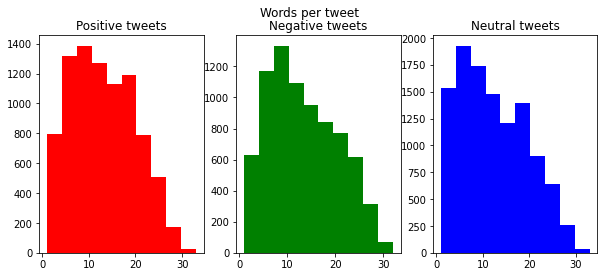

In [ ]:
# PLOTTING WORD-COUNT
fig,(ax1, ax2, ax3)=plt.subplots(1,3,figsize=(10,4))
train_words=train_df[train_df['sentiment']=='positive']['word_count']
ax1.hist(train_words,color='red')
ax1.set_title('Positive tweets')
train_words=train_df[train_df['sentiment']=='neutral']['word_count']
ax3.hist(train_words,color='blue')
ax3.set_title('Neutral tweets')
train_words=train_df[train_df['sentiment']=='negative']['word_count']
ax2.hist(train_words,color='green')
ax2.set_title('Negative tweets')
fig.suptitle('Words per tweet')
plt.show()

In [ ]:
# CHARACTER-COUNT
train_df['char_count'] = train_df['text'].apply(lambda x: len(str(x)))
print(train_df[train_df['sentiment']== 'positive']['char_count'].mean()) #Positive tweets
print(train_df[train_df['sentiment']== 'negative']['char_count'].mean()) #Negative tweets
print(train_df[train_df['sentiment']== 'neutral']['char_count'].mean()) #Neutral tweets

70.41913306921464
70.4881120678576
65.20680039579022


In [ ]:
#convert to lowercase, strip and remove extra spaces
def preprocess(text):
    text = text.lower() 
    text=text.strip()  
    #text=re.compile('<.*?>').sub('', text) # remove any character enclosed in '<XXXXX>'
    #text = re.compile('[%s]' % re.escape(string.punctuation)).sub('', text)  # remove punctuations
    #text = re.sub('[^\w\s*]', '', text)  # remove punctuations
    text = re.sub(r'[^\w\s\*\']+', '', text) # remove punctuations
    text = re.sub(r"http\S+", "", text) # remove urls
    #text = re.sub(r'\[[0-9]*\]','',text)  # remove digits
    #text=re.sub(r'[^\w\s*]', '', str(text).lower().strip()) # remove non-word and whitespace
    #text = re.sub(r'\d','',text) # remove all digits
    #text = re.sub(r'\s+',' ',text) # remove all whitespaces
    return text

def find_indexes(str1_tokens, str2_tokens, sentiment):
  #print(str1_tokens,'\n',str2_tokens,'\n', sentiment)
  start= 0
  end = 0
  found = False
  start_token = str2_tokens[0]
  end_token = str2_tokens[len(str2_tokens)-1]
  if sentiment == 'neutral':
    end = len(str1_tokens)
    found = True
  else:
    for idx_start, token in enumerate(str1_tokens):
      if token == start_token:
        start = idx_start
        found = True
        end = start + len(str2_tokens)
        break
  if start == end and found == True:
    end = end+1     
  elif found == False :
    start = -1
    end = -1
  else:
    start = start  
    end = end
  return start, end


def finalpreprocess(string):
    return preprocess(string)

def sent_embeddings(sentence, model):
  sent_vector = model.infer_vector(sentence)
  return sent_vector



In [ ]:
train_df['clean_text'] = train_df['text'].apply(lambda x: finalpreprocess(x))
train_df['clean_sel_text'] = train_df['selected_text'].apply(lambda x: finalpreprocess(x))
train_df['clean_text_tokens']=[nltk.word_tokenize(i) for i in train_df['clean_text']]
train_df['clean_sel_text_tokens']=[nltk.word_tokenize(i) for i in train_df['clean_sel_text']]
train_df['cl_sel_length'] = train_df.clean_sel_text_tokens.str.len()
train_df['cl_length'] = train_df.clean_text_tokens.str.len()

In [ ]:
# drop columns with empty text after preprocessing
train_df = train_df.drop(train_df[train_df.cl_sel_length == 0].index)
train_df = train_df.drop(train_df[train_df.cl_length == 0].index)

In [ ]:
train_df.shape

(27479, 12)

In [ ]:
# get start and end index of selected text tokens from original text tokens
idx_list = train_df.apply(lambda x: find_indexes(x.clean_text_tokens, x.clean_sel_text_tokens, x.sentiment), axis=1).tolist()

In [ ]:
# unzip tuples and add to dataframe
start_idx , end_idx = zip(*idx_list) 
train_df['start_idx']  = pd.Series(start_idx)
train_df['end_idx']  = pd.Series(end_idx)
train_df = train_df.reset_index(drop=True)

# remove all columns where start and end indices are -1
train_df = train_df.drop(train_df[train_df['start_idx'] == -1 ].index)


In [ ]:
train_df[train_df['start_idx'] == -1][['clean_text_tokens', 'sentiment', 'selected_text', 'clean_sel_text_tokens', 'start_idx', 'end_idx']]
train_df.shape


(26254, 14)

In [ ]:
PATH = f'/content/drive/MyDrive/Project_ML/'

In [ ]:
class TaggedWikiDocument(object):
    def __init__(self, wiki):
        self.wiki = wiki
        self.wiki.metadata = True
    def __iter__(self):
        for content, (page_id, title) in self.wiki.get_texts():
            yield TaggedDocument([c for c in content], [title])

In [ ]:
# https://markroxor.github.io/gensim/static/notebooks/doc2vec-wikipedia.html
# https://radimrehurek.com/gensim/corpora/wikicorpus.html
# enwiki-latest-pages-articles.xml.bz2
path_to_wiki_dump = datapath("enwiki-latest-pages-articles1.xml-p000000010p000030302-shortened.bz2")
wiki = WikiCorpus(path_to_wiki_dump)
documents = TaggedWikiDocument(wiki)
#tagged_data = [TaggedDocument(words=word_tokenize(_d.lower()), tags=[str(i)]) for i, _d in enumerate(train_df['clean_text']+ train_df['clean_sel_text'])]

cores = multiprocessing.cpu_count()

# build Doc2Vec model
# https://radimrehurek.com/gensim/auto_examples/tutorials/run_doc2vec_lee.html

max_epochs = 100
vec_size = 100
alpha = 0.025

model = Doc2Vec(vector_size=vec_size, dm=0, dbow_words=1, window=8, min_count=19, workers=cores, alpha=alpha, min_alpha=0.00025)
#Doc2Vec(vector_size=vec_size, alpha=alpha, min_alpha=0.00025, min_count=1, dm =0) # dm=1 preserves order of words in a sentence (distributed memory) 
                                                                                          # d=0 (distributed BOW) which doesn't consider order of words in sentence
model.build_vocab(documents)

for epoch in range(max_epochs):
    print('iteration {0}'.format(epoch))
    model.train(documents, total_examples=model.corpus_count, epochs=model.epochs)
    # decrease the learning rate
    model.alpha -= 0.0002
    # fix the learning rate, no decay
    model.min_alpha = model.alpha

model.save(PATH+"d2v.model")


In [ ]:
# Load the model
modeld2v= Doc2Vec.load(PATH+"d2v.model")

In [ ]:
# converting text to numerical data using Doc3vec
train_df['clean_text_embeds'] =  train_df.apply(lambda x: sent_embeddings(x.clean_text_tokens, modeld2v), axis=1)
#clean_text_embeds =  train_df.apply(lambda x: sent_embeddings(x.clean_text_tokens, modeld2v), axis=1)

In [ ]:
train_final_df = pd.DataFrame(train_df['clean_text_embeds'].tolist())
train_df = pd.concat([train_df, train_final_df], axis=1)

#train_df.head()


In [ ]:
# encode sentiment variable
# https://contrib.scikit-learn.org/category_encoders/binary.html
train_df['sentiment_en'] = train_df['sentiment']
binary_encoder= ce.BinaryEncoder(cols=['sentiment_en'],return_df=True)
train_df=binary_encoder.fit_transform(train_df) 

# inverse transform
#train_df = binary_encoder.inverse_transform(train_df)


In [ ]:
# drop na values from final df
train_df = train_df.dropna()
#train_df = train_df.drop('index', axis=1)
#train_df.isna().any()
#train_df.head()
train_df.shape


(25068, 118)

In [ ]:
# prepare data for training.
train_final_df['sentiment_en_0'] = train_df['sentiment_en_0']
train_final_df['sentiment_en_1'] = train_df['sentiment_en_1']
train_final_df['start_idx'] = train_df['start_idx']
train_final_df['end_idx'] = train_df['end_idx']
train_final_df['clean_text_tokens'] = train_df['clean_text_tokens']
train_final_df['sentiment'] = train_df['sentiment']


# drop na rows from final df
train_final_df = train_final_df.dropna()
train_final_df[['start_idx', 'end_idx', 'sentiment_en_0', 'sentiment_en_1']] = train_final_df[['start_idx','end_idx', 'sentiment_en_0', 'sentiment_en_1']].astype(int)



/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:3641: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


In [ ]:
train_df[train_df['end_idx']==train_df['start_idx']+1][['clean_text_tokens', 'sentiment', 'selected_text', 'start_idx', 'end_idx']].head()
#print(train_final_df.columns)
#print(train_final_df.isna().sum())
print(train_df.shape)

(25068, 118)


In [ ]:
#SPLITTING THE TRAINING DATASET INTO TRAIN AND TEST
#X_train, X_test, y_train, y_test = train_test_split(train_df[["clean_text", 'sentiment_en']],train_df["clean_sel_text"],test_size=0.2,shuffle=True)
#X_train, X_test, y_train, y_test = train_test_split(train_df[["clean_text_embeds", 'sentiment_en_0', 'sentiment_en_0']].values ,train_df[['start_idx', 'end_idx']].values, test_size=0.2, shuffle=True)
X = train_final_df.drop(['start_idx', 'end_idx'], axis=1)
y = train_final_df[['start_idx', 'end_idx']].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

In [ ]:
#building Word2Vec model
class EmbedVector():
  def __init__(self, model_w2v):
    self.model_w2v = model_w2v
    self.dim = len(next(iter(model_w2v.values())))
  def transform(self, X):
    return np.array([np.mean([self.model_w2v[w] for w in words if w in self.model_w2v] or [np.zeros(self.dim)], axis=0) for words in X ])

# tokenize sentences
X_train_tokens= [nltk.word_tokenize(i) for i in X_train]  
X_test_tokens= [nltk.word_tokenize(i) for i in X_test]

model_w2v = Word2Vec(train_df['clean_text_tokens']+ train_df['clean_sel_text_tokens'])     
w2v = dict(zip(model_w2v.wv.index2word, model_w2v.wv.vectors)) 
modelw = EmbedVector(w2v)

In [ ]:
# converting text to numerical data using Word2Vec
X_train_vect_w2v = modelw.transform(X_train_tokens)
X_val_vect_w2v = modelw.transform(X_test_tokens)

In [ ]:
# Prepare final values for X (train & test)
X_train_final = X_train.drop(['clean_text_tokens', 'sentiment'], axis=1).values
X_test_final = X_test.drop(['clean_text_tokens', 'sentiment'], axis=1).values

In [ ]:
# https://towardsdatascience.com/5x-faster-scikit-learn-parameter-tuning-in-5-lines-of-code-be6bdd21833c
# https://docs.ray.io/en/latest/tune/api_docs/sklearn.html
def build_search_model(param_grid, model, X_train, y_train, n_splits=3,  refit=True, verbose=False):
  mse = make_scorer(mean_squared_error,greater_is_better=False)
  clf = TuneSearchCV(estimator=model, n_jobs=-1, verbose=verbose, param_distributions=param_grid, scoring=mse, cv=n_splits, refit=refit, search_optimization='hyperopt', early_stopping=False, max_iters=10) # 'hyperopt', 'bohb', 'random', 'bayesian'
  #clf = TuneGridSearchCV(estimator=model, n_jobs=-1, verbose=verbose, param_grid=param_grid, scoring=mse, cv=n_splits, refit=refit, early_stopping=False, max_iters=10)
  clf = clf.fit(X_train, y_train, early_stopping_round=6) 
  return clf

In [ ]:
# Define param_grid
xgb_param_grid = {
    'estimator__max_depth': [10, 11, 12],
    'estimator__n_estimators': [200, 500, 1000],
    'estimator__learning_rate': [0.1, 0.01, 0.001, 0.004],
    'estimator__random_state': [1],
    'estimator__subsample':[0.7, 0.8, 0.5, 0.6]
    #'estimator__tree_method':['gpu_hist']
  }

In [ ]:
# define model
model = MultiOutputRegressor(XGBRegressor(objective='reg:squarederror', n_jobs=-1, nthread=4))
start_time = time.time()
clf = build_search_model(xgb_param_grid, model, X_train_final, y_train, verbose=True)
seconds = time.time() - start_time
print('Time Taken:', time.strftime("%H:%M:%S",time.gmtime(seconds)))
xgb_estimator = clf.best_estimator_
# save model
dump(xgb_estimator, PATH+'xgb.joblib') 

2022-04-05 02:25:41,944	INFO tune.py:610 -- Total run time: 9580.76 seconds (9574.64 seconds for the tuning loop).
/usr/local/lib/python3.7/dist-packages/xgboost/core.py:613: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn("Use subset (sliced data) of np.ndarray is not recommended " +


Time Taken: 02:51:48


In [ ]:
# load saved model
xgb_estimator = load(PATH+'xgb.joblib') 

y_hat = xgb_estimator.predict(X_test_final)
#print(y_test)
#print(y_hat)

In [ ]:
mse = mean_squared_error(y_test, y_hat) 
rmse = math.sqrt(mse)
print("Root Mean Square Error:\n")
print(rmse)

Root Mean Square Error:

5.776564729417875


In [ ]:
X_test['clean_text_tokens'].reset_index(drop=True).tolist()

In [ ]:
df_pred = pd.DataFrame(y_hat, columns = ['pred_start','pred_end']).astype(int)
df_actual = pd.DataFrame(y_test, columns = ['start','end']).astype(int)
s = pd.Series(X_test['clean_text_tokens'])
df_toks = pd.DataFrame(pd.Series(X_test['clean_text_tokens'].reset_index(drop=True).tolist()), columns=['clean_text_tokens']).astype(object)
df_sent = pd.DataFrame(pd.Series(X_test['sentiment'].reset_index(drop=True).tolist()), columns=['sentiment']).astype(object)
list = [df_actual, df_pred, df_toks, df_sent]
df_final = pd.concat(list, axis=1)
# reset index
#df_final = df_final.reset_index(drop=True)
df_final

,start,end,pred_start,pred_end,clean_text_tokens,sentiment
0,0,11,2,9,"[i, have, had, the, worst, headache, ever, in,...",negative
1,0,13,1,9,"[had, a, really, weird, night, last, night, an...",negative
2,0,11,2,9,"[you, should, enter, the, giveaway, then, who,...",neutral
3,0,6,2,8,"[u, mean, vip, this, time, coz, of, the, kbs, ...",neutral
4,0,11,2,9,"[has, finally, found, her, new, flat]",neutral
...,...,...,...,...,...,...
5009,11,24,2,9,"[seeing, the, gf, 5, days, in, a, row, for, a,...",positive
5010,2,5,2,9,"[mom, just, woke, me, up, and, i, am, so, mad,...",negative
5011,2,3,2,8,"[she, could, spend, the, rest, of, the, night,...",positive
5012,4,6,2,9,"[moving, today, im, so, excited]",positive


In [ ]:
#df_final['original_text_tokens'] = X_test['clean_text_tokens']
df_final.isna().sum()

start                0
end                  0
pred_start           0
pred_end             0
clean_text_tokens    0
sentiment            0
dtype: int64

In [ ]:
def get_sel_text_from_index(start, end, original_tokens, sentiment):
  sel_text = ''
  if sentiment == 'neutral':
    sel_text_tokens = original_tokens
  else:
    sel_text_tokens = original_tokens[start:end]  
    
  sel_text = " ".join(sel_text_tokens)
  return sel_text


In [ ]:
df_final['pred_sel_text'] = df_final.apply(lambda x: get_sel_text_from_index(x.pred_start, x.pred_end, x.clean_text_tokens, x.sentiment), axis=1).tolist()
df_final['act_sel_text'] = df_final.apply(lambda x: get_sel_text_from_index(x.start, x.end, x.clean_text_tokens, x.sentiment), axis=1).tolist()

In [ ]:
# Metric Jaccard score

def jaccard(str1, str2): 
    a = set(str1.lower().split()) 
    b = set(str2.lower().split())
    if (len(a)==0) & (len(b)==0): return 0.5
    c = a.intersection(b)
    return float(len(c)) / (len(a) + len(b) - len(c))

In [ ]:
df_final['jaccard_score'] = df_final.apply(lambda x: jaccard(x.act_sel_text, x.pred_sel_text), axis=1).tolist()

In [ ]:
jaccard_acc = df_final['jaccard_score'].mean()
#print(df_final.head())
print('Jaccard accuracy is : ', jaccard_acc)

Jaccard accuracy is :  0.6108928058592357


In [ ]:
#Test block for development

find_indexes(train_df['clean_text_tokens'][0], train_df['clean_sel_text_tokens'][0], 'neutral')
print(train_df['clean_text_tokens'][0])

['i', 'd', 'have', 'responded', 'if', 'i', 'were', 'going']


In [ ]:
# Doc2Vec Testing

#to find the vector of a document which is not in training data
test_data = word_tokenize("I love chatbots".lower())
v1 = modeld2v.infer_vector(test_data)
print("V1_infer", v1)

# to find most similar doc using tags
similar_doc = modeld2v.docvecs.most_similar('1')
print(similar_doc)


# to find vector of doc in training data using tags or in other words, printing the vector of document at index 1 in training data
print(modeld2v.docvecs['1'])

V1_infer [-0.00823853  0.0125465  -0.05362745 -0.00804744 -0.03190618 -0.00868102
 -0.04342219  0.04068456  0.02885487 -0.00139011 -0.0370013   0.01534083
 -0.0025305  -0.05201721  0.03253455 -0.0085752   0.02434799 -0.07629792
 -0.01320806  0.05194129 -0.03206015 -0.0479126   0.00537943  0.00213766
 -0.02185634 -0.09854241  0.00201005  0.02742022 -0.0083191   0.04130479
  0.06971811 -0.0339016   0.01470919 -0.04786061  0.0945525  -0.01840335
  0.03125513 -0.02065532 -0.02845261  0.0605186 ]
[('24906', 0.7340426445007324), ('7594', 0.7134906053543091), ('19114', 0.6855695247650146), ('4375', 0.6833310127258301), ('24921', 0.6669832468032837), ('17490', 0.6641349196434021), ('23033', 0.6558976173400879), ('5369', 0.6542665362358093), ('1187', 0.6504262685775757), ('15201', 0.6486458778381348)]
[-2.5872064  -0.08458285 -2.4285684  -0.7263068  -1.7792158  -0.64430296
 -1.2457631  -2.4194722   0.70136184  2.796983    0.24344538  2.8644936
 -0.9671128  -3.1667988  -2.7575698   1.5393171  -1

In [ ]:
tokens = ['I', 'Love', 'You', 'Baby', '!']
sel = ['Love', 'You']
len(sel)

start_tok=1
end_tok = start_tok+ len(sel)
end_tok

tokens[start_tok: end_tok]

['Love', 'You']